# Setup

In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import helpers

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


# Create Tracks

In [3]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

# base_dir = '/home/student.unimelb.edu.au/shorte1'
# base_dir += '/Documents/caine_WRF_data/'

save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'

micro_physics = 'lin'

dates = np.arange(
    np.datetime64('2006-02-09 00:00'), 
    np.datetime64('2006-02-13 12:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = caf.caine_files_from_datetime_list(
    dates, micro_physics=micro_physics, 
    base_dir=base_dir)

Gathering files.


In [543]:
filenames

["/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:00:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:10:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:20:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:30:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:40:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T00:50:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:00:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:10:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/caine_WRF_data/lind04_ref/lind04_ref_2006-02-09T01:20:00.nc",
 "/media/shorte1/Ewan's Hard Drive/phd/data/ca

In [544]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [545]:
def gen_tracks(filenames, rain=False, micro_physics='thompson'):

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
    b_path += 'CPOL_analysis/circ_b_ind_set.pkl' 
    
    tracks_obj  = tint.Tracks()
    
    current_time = str(datetime.datetime.now())[0:-7]
    current_time = current_time.replace(" ", "_").replace(":", "_")
    current_time = current_time.replace("-", "")
        
#     %lprun -T lprof0 -f tint.tracks.Cell_tracks.get_tracks tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids, b_path=None)
    #tracks_obj = helpers.get_reanalysis_vars(tracks_obj)
    #tracks_obj = helpers.add_monsoon_regime(tracks_obj)
 
    out_file_name = save_dir + 'tracks_obj_{}_{}.pkl'.format(
        micro_physics, current_time)

#     with open(out_file_name, 'wb') as f:
#         pickle.dump(tracks_obj, f)
        
    return tracks_obj

In [541]:
thompson_tracks_obj = copy.deepcopy(tracks_obj)

In [546]:
lin_tracks_obj = gen_tracks(filenames, micro_physics=micro_physics)

No objects found in scan 0.
No objects found in scan 1.
No objects found in scan 2.
No objects found in scan 3.
No objects found in scan 4.
No objects found in scan 5.
No objects found in scan 6.
No objects found in scan 7.
No objects found in scan 8.
No objects found in scan 9.
No objects found in scan 10.
No objects found in scan 11.
No objects found in scan 12.
No objects found in scan 13.
No objects found in scan 14.
No objects found in scan 15.
No objects found in scan 16.
No objects found in scan 17.
No objects found in scan 18.
No objects found in scan 19.
No objects found in scan 20.
No objects found in scan 21.
No objects found in scan 22.
No objects found in scan 23.
No objects found in scan 24.
No objects found in scan 25.
No objects found in scan 26.
No objects found in scan 27.
No objects found in scan 28.
No objects found in scan 29.
No objects found in scan 30.
No objects found in scan 31.
No objects found in scan 32.
No objects found in scan 33.
No objects found in scan

No objects found in scan 280.
No objects found in scan 281.
No objects found in scan 282.
No objects found in scan 283.
No objects found in scan 284.
No objects found in scan 285.
No objects found in scan 286.
No objects found in scan 287.
No objects found in scan 288.
No objects found in scan 289.
No objects found in scan 290.
Writing tracks for scan 291.
Writing tracks for scan 292.
Writing tracks for scan 293.
Writing tracks for scan 294.
Writing tracks for scan 295.
Writing tracks for scan 296.
Writing tracks for scan 297.
Writing tracks for scan 298.
Writing tracks for scan 299.
Writing tracks for scan 300.
Writing tracks for scan 301.
Writing tracks for scan 302.
Writing tracks for scan 303.
Writing tracks for scan 304.
Writing tracks for scan 305.
Writing tracks for scan 306.
Writing tracks for scan 307.
Writing tracks for scan 308.
Writing tracks for scan 309.
Writing tracks for scan 310.
Writing tracks for scan 311.
Writing tracks for scan 312.
Writing tracks for scan 313.
Wri

No objects found in scan 556.
No objects found in scan 557.
No objects found in scan 558.
No objects found in scan 559.
No objects found in scan 560.
No objects found in scan 561.
No objects found in scan 562.
No objects found in scan 563.
No objects found in scan 564.
No objects found in scan 565.
No objects found in scan 566.
No objects found in scan 567.
No objects found in scan 568.
No objects found in scan 569.
No objects found in scan 570.
No objects found in scan 571.
No objects found in scan 572.
No objects found in scan 573.
No objects found in scan 574.
No objects found in scan 575.
No objects found in scan 576.
No objects found in scan 577.
No objects found in scan 578.
No objects found in scan 579.
No objects found in scan 580.
No objects found in scan 581.
No objects found in scan 582.
No objects found in scan 583.
No objects found in scan 584.
No objects found in scan 585.
No objects found in scan 586.
No objects found in scan 587.
No objects found in scan 588.
No objects

# Load Tracks

In [6]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_2001_2002.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_2001_2002.pkl'

> /tmp/ipykernel_9012/1828939310.py(1)<module>()
----> 1 with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_2001_2002.pkl', 'rb') as f:
      2     tracks_obj = pickle.load(f)

ipdb> q


# Create Figures

In [6]:
set(tracks_obj.tracks.index.get_level_values('uid').values)

{'0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9'}

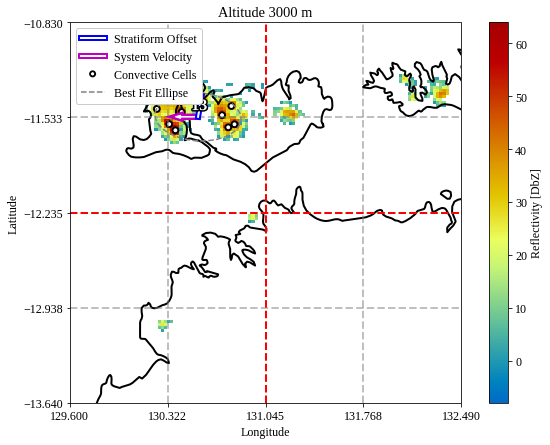

In [14]:
filename = filenames[503]
grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 7, 'winds': False, 'winds_fn': filename, 
    'crosshair': True}

tint.visualisation.figures.horizontal_cross_section(
    tracks_obj, grid, params=params, alt=3000)
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/example2.png', dpi=200, facecolor='w')

In [23]:
np.sin(np.deg2rad(90))

1.0

In [15]:
grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
uid_ind = '13'

params = {
    'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
    'cell_ind': 7, 'winds': True, 'winds_fn': filename,
    'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
    'line_average': True, 'streamplot': True, 'relative_winds': True,
    'data_fn': 'angles', 'load_line_coords_winds': True}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

Transformed data not found. Calculating.
Interpolating onto line coordinates.
Calculating horizontal winds in new basis.
Adding reflectivity.
Adding stratiform offset.
Adding winds.
Saving data.


In [10]:
for uid_ind in np.arange(14).astype(str):
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

    params = {
        'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filenames, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': False}

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    tint.visualisation.animate.animate(tracks_obj, grids, params)

Generating frame 2006-02-09T11:50:00.000000000
Interpolating onto line coordinates.
Calculating horizontal winds in new basis.
Adding reflectivity.
Adding stratiform offset.
Adding winds.
Saving data.
Creating new CSV file to store angle data.
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(334)save_tilt_data()
    332 
    333     import pdb; pdb.set_trace()
--> 334     fn = '{}/{}.csv'.format(params['save_dir'], params['data_fn'])
    335     df.reset_index(inplace=True)
    336     df.to_csv(fn, index=False)

ipdb> c
Generating frame 2006-02-09T12:00:00.000000000
Interpolating onto line coordinates.
Calculating horizontal winds in new basis.
Adding reflectivity.
Adding stratiform offset.
Adding winds.
Saving data.
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/figures.py(334)save_tilt_data()
    332 
    333     import pdb; pdb.set_trace()
--> 334     fn = '{}/{}.csv'.format(params['save_dir'], params['data_fn'])
    335 

BdbQuit: 

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/bdb.py(154)dispatch_return()
    152             finally:
    153                 self.frame_returning = None
--> 154             if self.quitting: raise BdbQuit
    155             # The user issued a 'next' or 'until' command.
    156             if self.stopframe is frame and self.stoplineno != -1:

ipdb> q


In [17]:
tint.visualisation.figures.concat_angles(
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_objects',
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_angles.csv',
    12)

,time,uid,streamline_angle,w_max,n_angles,n_obs,max_count,stratiform_offset_angle
0,2006-02-09 08:30:00,0,151.25,2.651685,168.0,820.0,10.0,89.419244
1,2006-02-09 08:40:00,0,91.25,5.463759,162.0,738.0,7.0,86.813102
2,2006-02-09 08:50:00,0,163.75,4.478228,90.0,902.0,15.0,155.353923
3,2006-02-09 09:00:00,0,138.75,2.239941,69.0,369.0,6.0,68.035144
4,2006-02-09 09:10:00,0,166.25,1.536123,30.0,1025.0,6.0,151.175068
...,...,...,...,...,...,...,...,...
9,2006-02-13 10:10:00,11,173.75,2.534968,72.0,779.0,27.0,162.513872
10,2006-02-13 10:20:00,11,173.75,1.882085,42.0,738.0,15.0,167.325305
11,2006-02-13 10:30:00,11,171.25,1.716105,30.0,656.0,6.0,167.377685
12,2006-02-13 10:40:00,11,138.75,5.096160,81.0,451.0,6.0,157.806306


In [504]:
lin_angles = pd.read_csv(
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_angles.csv')
thompson_angles = pd.read_csv(
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/thompson_angles.csv')

In [509]:
angles = thompson_angles.dropna()

In [548]:
x = 1
y = 2
z = 3
props = [x, y, z]
props = [p+10 for p in props]
props[1]

12

In [551]:
def get_angle_props(angles, tracks_obj):
    angle_diff = np.abs(
        angles['streamline_angle'] - angles['stratiform_offset_angle'])
    w_max = angles['w_max'].values
    max_count = angles['max_count'].values
    n_angles = angles['n_angles'].values
    n_obs = angles['n_obs'].values
    ratio_angles = n_angles / n_obs
    ratio_bin = max_count / n_angles
    
    eccentricity = []
    bor_conv = []
    bor_strat = []
    area_conv = []
    area_strat = []
    u_shift = []
    v_shift = []

    for i in range(len(angles)):
        date_time = angles['time'].iloc[i]
        uid = angles['uid'].iloc[i]
        tmp_tracks_low = tracks_obj.tracks.xs(
            (date_time, str(int(uid)), 0), level=('time', 'uid', 'level'))
        tmp_tracks_high = tracks_obj.tracks.xs(
            (date_time, str(int(uid)), 2), level=('time', 'uid', 'level'))
        eccentricity.append(tmp_tracks_low['eccentricity'].iloc[0])
        u_shift.append(tmp_tracks_low['u_shift'].iloc[0])
        v_shift.append(tmp_tracks_low['v_shift'].iloc[0])
        bor_conv.append(tmp_tracks_low['touch_border'].iloc[0])
        bor_strat.append(tmp_tracks_high['touch_border'].iloc[0])
        area_conv.append(tmp_tracks_low['proj_area'].iloc[0])
        area_strat.append(tmp_tracks_high['proj_area'].iloc[0])
    [u_shift, v_shift] = [np.array(u_shift), np.array(v_shift)]
    eccentricity = np.array(eccentricity)
    [bor_conv, bor_strat] = [np.array(bor_conv), np.array(bor_strat)]
    [area_conv, area_strat] = [np.array(area_conv), np.array(area_strat)]
    speed = np.sqrt(u_shift ** 2 + v_shift ** 2)
    ratio_border_conv = bor_conv * 6.25 / area_conv
    ratio_border_strat = bor_strat * 6.25 / area_strat
    
    X = np.transpose(np.array([
        w_max, ratio_angles, ratio_bin, ratio_border_conv, 
        ratio_border_strat, area_conv, area_strat, eccentricity, 
        speed]))
    names = [
        'w_max', 'ratio_angles', 'ratio_bin', 'ratio_border_conv', 
        'ratio_border_strat', 'area_conv', 'area_strat', 
        'eccentricity', 'speed']
    
    return angle_diff, X, names

In [583]:
angle_diff_t, X_t, names = get_angle_props(thompson_angles.dropna(), thompson_tracks_obj)
angle_diff_l, X_l, names = get_angle_props(lin_angles.dropna(), lin_tracks_obj)
angle_diff = np.concatenate([angle_diff_t, angle_diff_l])
X = np.concatenate([X_t, X_l])
sl_angles_t = thompson_angles.dropna()['streamline_angle'].values
so_angles_t = thompson_angles.dropna()['stratiform_offset_angle'].values
sl_angles_l = lin_angles.dropna()['streamline_angle'].values
so_angles_l = lin_angles.dropna()['stratiform_offset_angle'].values
sl_angles = np.concatenate([sl_angles_t, sl_angles_l])
so_angles = np.concatenate([so_angles_t, so_angles_l])

In [562]:
X.shape

(359, 9)

In [566]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(min_samples_split=40)
clf.fit(X, angle_diff)

DecisionTreeRegressor(min_samples_split=40)

In [567]:
print(tree.export_text(
    clf, feature_names=names, max_depth=9, show_weights=True))

|--- speed <= 7.48
|   |--- area_strat <= 5228.12
|   |   |--- speed <= 3.49
|   |   |   |--- value: [60.69]
|   |   |--- speed >  3.49
|   |   |   |--- ratio_bin <= 0.06
|   |   |   |   |--- value: [48.49]
|   |   |   |--- ratio_bin >  0.06
|   |   |   |   |--- ratio_angles <= 0.17
|   |   |   |   |   |--- area_strat <= 3831.25
|   |   |   |   |   |   |--- eccentricity <= 0.59
|   |   |   |   |   |   |   |--- value: [56.78]
|   |   |   |   |   |   |--- eccentricity >  0.59
|   |   |   |   |   |   |   |--- eccentricity <= 0.93
|   |   |   |   |   |   |   |   |--- ratio_bin <= 0.09
|   |   |   |   |   |   |   |   |   |--- value: [39.48]
|   |   |   |   |   |   |   |   |--- ratio_bin >  0.09
|   |   |   |   |   |   |   |   |   |--- value: [13.76]
|   |   |   |   |   |   |   |--- eccentricity >  0.93
|   |   |   |   |   |   |   |   |--- value: [37.92]
|   |   |   |   |   |--- area_strat >  3831.25
|   |   |   |   |   |   |--- value: [68.26]
|   |   |   |   |--- ratio_angles >  0.17
|   | 

[Text(409.20000000000005, 774.63, 'speed <= 7.477\nmse = 915.047\nsamples = 359\nvalue = 24.607'),
 Text(223.20000000000002, 693.09, 'area_strat <= 5228.125\nmse = 1317.022\nsamples = 133\nvalue = 37.096'),
 Text(148.8, 611.55, 'speed <= 3.486\nmse = 847.749\nsamples = 122\nvalue = 31.316'),
 Text(74.4, 530.01, 'mse = 841.479\nsamples = 15\nvalue = 60.687'),
 Text(223.20000000000002, 530.01, 'ratio_bin <= 0.061\nmse = 710.749\nsamples = 107\nvalue = 27.199'),
 Text(148.8, 448.47, 'mse = 1425.971\nsamples = 8\nvalue = 48.492'),
 Text(297.6, 448.47, 'ratio_angles <= 0.169\nmse = 613.353\nsamples = 99\nvalue = 25.478'),
 Text(223.20000000000002, 366.93, 'area_strat <= 3831.25\nmse = 718.574\nsamples = 70\nvalue = 29.368'),
 Text(148.8, 285.39, 'eccentricity <= 0.587\nmse = 633.691\nsamples = 65\nvalue = 26.377'),
 Text(74.4, 203.85000000000002, 'mse = 1524.987\nsamples = 6\nvalue = 56.782'),
 Text(223.20000000000002, 203.85000000000002, 'eccentricity <= 0.93\nmse = 439.472\nsamples = 59\n

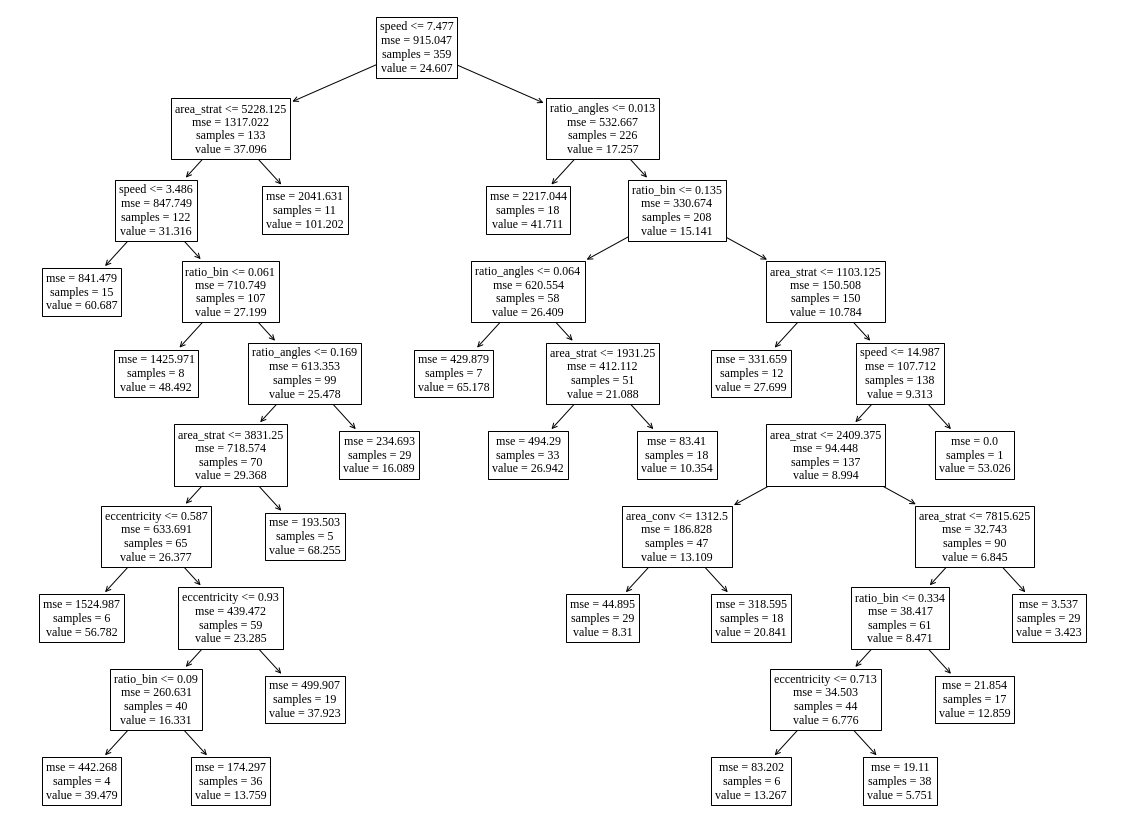

In [568]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
tree.plot_tree(
    clf, max_depth=10, ax=ax, feature_names=names, fontsize=12)

In [576]:
[
        w_max, ratio_angles, ratio_bin, ratio_border_conv, 
        ratio_border_strat, area_conv, area_strat, eccentricity, 
        speed] = [X[:,i] for i in range(X.shape[1])]

In [578]:
# Combined criteria
cond1 = speed > 7.477
cond2 = ratio_angles > 0.013
cond3 = ratio_bin > 0.135
cond5 = np.array(area_strat) > 1103.125
cond6 = speed <= 14.987
cond7 = np.array(ratio_border_conv) <= 0.037
cond8 = np.array(area_conv) > 325.0
cond = cond1 & cond2 & cond3 & cond5 # & cond5 & cond7

In [569]:
# Thompson split criteria
cond1 = speed > 7.568
cond2 = ratio_angles > 0.013
cond3 = ratio_bin > 0.082
cond4 = speed <= 14.987
cond5 = np.array(area_strat) > 1650
cond6 = np.array(ratio_border_conv) <= 0.037
cond7 = np.array(area_conv) > 325.0
cond = cond1 & cond2 & cond3 & cond4 # & cond5 & cond7

In [524]:
cond1a = (ratio_angles <= 0.021)
cond1b = (ratio_angles > 0.021) & (ratio_bin <= 0.213)
cond1 = (speed <= 7.568) & (ratio_angles > 0.001) & (ratio_bin > 0.055) & (speed > 4.93) & (cond1a | cond1b)
cond2a = (speed <= 10.09)
cond2b = (speed > 10.09) & (ratio_bin > 0.137)
cond2 = (speed > 7.568) & (ratio_angles > 0.013) & (ratio_bin > 0.082) & (speed <= 14.987) & (cond2a | cond2b)
cond = cond1 | cond2

In [374]:
# Lin split criteria
cond1 = speed > 0
cond2 = ratio_angles > 0.011
cond3 = ratio_bin > 0.127
cond4 = w_max > 1
cond = cond1 & cond2 & cond3 & cond4

In [386]:
# Lin split criteria
cond1 = (ratio_bin > 0.221) & (speed > 6.943) & (eccentricity > 0.679)
cond2 = (
    (ratio_bin <= 0.221) & (ratio_angles > 0.011) & (w_max > 2.243)
    & (
        ((ratio_bin > 0.116) & (speed > 3.676)) 
        | ((ratio_bin <= 0.113) & (ratio_bin > 0.049))))
cond = cond1 | cond2

In [534]:
len(cond[cond==True])

51

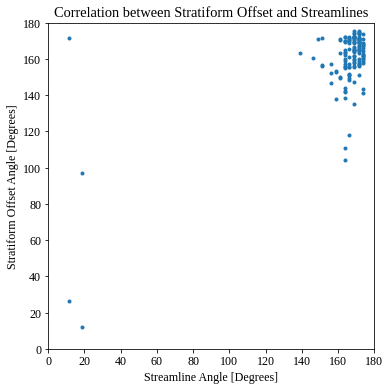

In [584]:
tint.visualisation.figures.init_fonts()
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sl_angles[cond], so_angles[cond], marker='.')
ax.set_xlim(0, 180)
ax.set_xticks(np.arange(0, 200, 20))
ax.set_xticklabels(np.arange(0, 200, 20).astype(int))
ax.set_xlabel('Streamline Angle [Degrees]')
ax.set_ylim(0, 180)
ax.set_yticks(np.arange(0, 200, 20))
ax.set_yticklabels(np.arange(0, 200, 20).astype(int))
ax.set_ylabel('Stratiform Offset Angle [Degrees]')
ax.set_title('Correlation between Stratiform Offset and Streamlines')
ax.set_aspect(1)

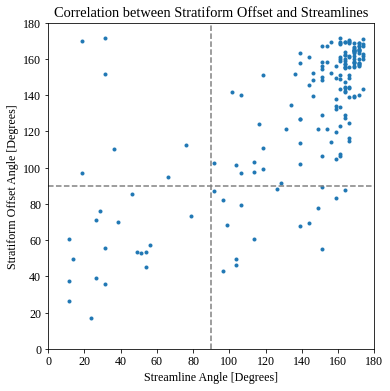

In [538]:
tint.visualisation.figures.angle_correlation(
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_angles.csv',
    '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/lin_angle_correlation.png')

In [15]:
np.rad2deg(np.arctan2(5.5,-30))

169.6111421845304

In [18]:
from skimage.transform import radon
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb

In [25]:
test = (image == 0).astype(int)

In [29]:
filename = filenames[36]
grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

params = {
    'uid_ind': '1', 'line_coords': False, 'center_cell': False, 
    'cell_ind': 4, 'winds': False, 'winds_fn': filename,
    'crosshair': True, 'save_dir': None, 'legend': False}

tint.visualisation.figures.object(tracks_obj, grid, params=params)

IndexError: list index out of range

> /tmp/ipykernel_21199/4030395361.py(1)<module>()
----> 1 filename = filenames[36]
      2 grid = pyart.io.read_grid(filename, include_fields = ['reflectivity'])
      3 fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
      4 
      5 params = {

ipdb> q


Interpolating onto line coordinates.
Calculating horizontal winds in new basis.


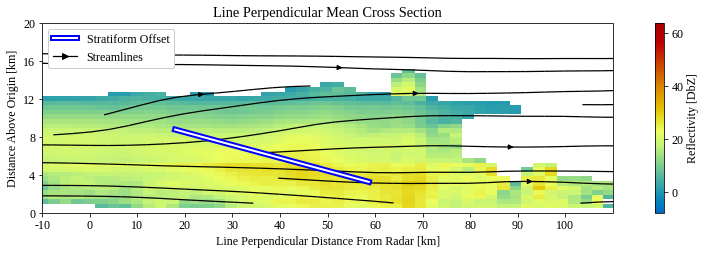

In [38]:
params = {
    'uid_ind': '1', 'line_coords': True, 'center_cell': False,
    'cell_ind': 4, 'direction': 'perpendicular', 'winds': True, 
    'winds_fn': filename, 'line_average': True, 'streamplot': True}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

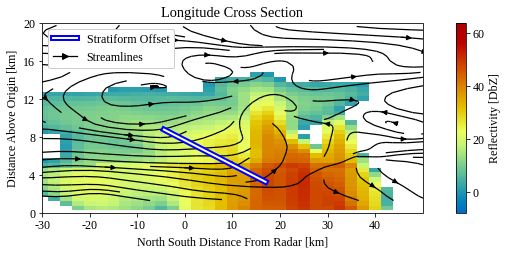

In [10]:
params = {
    'uid_ind': '2', 'line_coords': False, 'center_cell': False,
    'cell_ind': 0, 'direction': 'lon', 'winds': True, 
    'winds_fn': filename, 'line_average': False, 'streamplot': True}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

## Create Animations

In [6]:
def make_animation(filenames, start_time, end_time):
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6
    
#     filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
#         tracks_obj_temp, '13', mp=mp
#     )
    
#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-01-12 14:00'), 
#                   np.datetime64('2003-01-12 16:40'), 
#                   np.timedelta64(10, 'm'))
#     )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:00'), 
#                   np.datetime64('2006-02-09 11:00'), 
#                   np.timedelta64(10, 'm')), mp='lin'
#     )
    
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    current_time = str(datetime.datetime.now())[0:-7]
    current_time = current_time.replace(" ", "_").replace(":", "_")
    current_time = current_time.replace("-", "")

    out_path = save_dir + current_time + '_tint_CPOL_anim'

    animate(
        tracks_obj, grids, out_path, start_datetime = start_time,
        end_datetime = end_time, alt_low=3000, alt_high=10000)

Animating from 2006-02-11T00:00 to 2006-02-11T02:50.


/home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py:315: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if grid_time > end_datetime:


> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(37)plot_tracks_horiz_cross()
     35 
     36     # Restrict tracks to time of grid
---> 37     time_ind = tracks.tracks.index.get_level_values('time')
     38     time_ind = np.array(time_ind).astype('datetime64[m]')
     39     # Below perhaps not necessary!

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(38)plot_tracks_horiz_cross()
     36     # Restrict tracks to time of grid
     37     time_ind = tracks.tracks.index.get_level_values('time')
---> 38     time_ind = np.array(time_ind).astype('datetime64[m]')
     39     # Below perhaps not necessary!
     40     grid_time = np.datetime64(grid.time['units'][14:]).astype('datetime64[m]')

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(40)plot_tracks_horiz_cross()
     38     time_ind = np.array(time_ind).astype('datetime64[m]')
     39     # Below perhaps not necessary!
---> 40     grid_time = np.datetim

/home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py:40: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  grid_time = np.datetime64(grid.time['units'][14:]).astype('datetime64[m]')


> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(41)plot_tracks_horiz_cross()
     39     # Below perhaps not necessary!
     40     grid_time = np.datetime64(grid.time['units'][14:]).astype('datetime64[m]')
---> 41     scan_ind = tracks.tracks.index.get_level_values('scan')
     42     try:
     43         nframe = scan_ind[time_ind == grid_time][0]

ipdb> grid_time
numpy.datetime64('2006-02-11T00:00')
ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(42)plot_tracks_horiz_cross()
     40     grid_time = np.datetime64(grid.time['units'][14:]).astype('datetime64[m]')
     41     scan_ind = tracks.tracks.index.get_level_values('scan')
---> 42     try:
     43         nframe = scan_ind[time_ind == grid_time][0]
     44     except:

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/figures.py(43)plot_tracks_horiz_cross()
     41     scan_ind = tracks.tracks.index.get_level_values('scan')
     42     try:
---> 43         nfra

BdbQuit: 

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

ipdb> q


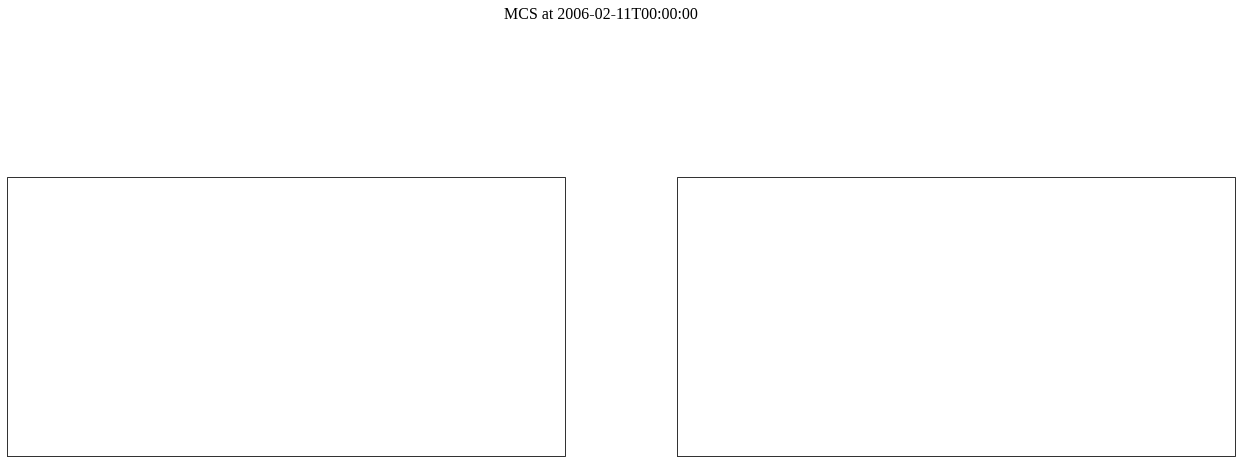

In [24]:
make_animation(filenames, start_time, end_time)

In [ ]:
def test():
    uid = '13'
    filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
        tracks_obj, uid, mp=mp    
    )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-12-20 08:20'), 
#                   np.datetime64('2003-12-20 08:30'), 
#                   np.timedelta64(10, 'm'))
#     )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:30'), 
#                   np.datetime64('2006-02-09 10:40'), 
#                   np.timedelta64(10, 'm')), mp=mp
#     )

    grids = (pyart.io.read_grid(fn) for fn in filenames)  
    # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + current_time + '_tint_CPOL'
    animate(tracks_obj, grids, out_path, style='full', 
            alt_low=3000, alt_high=10000, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=False, wrf_winds=False, line_coords=False,
            average_along_line=False, quiver=False, mp=micro_physics)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

# Create Categories

In [7]:
categories = helpers.create_categories(tracks_obj)

In [8]:
subset_logic = (categories['not_border'] & categories['not_border_0'] 
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary'] 
                & categories['sig_vel_mag'])
sub_cat = categories[subset_logic]

In [9]:
uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

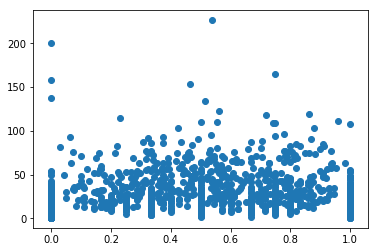

In [10]:
tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

In [73]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

Series([], Name: par_align, dtype: bool)

# Calculate Some Statistics

## PS, TS, LS Breakdown

In [34]:
subset_logic = sig_area & not_border & not_border_0 & sig_vel_mag & sig_tilt_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, totals] = [np.zeros(100) for i in range(4)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

## System Size

In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


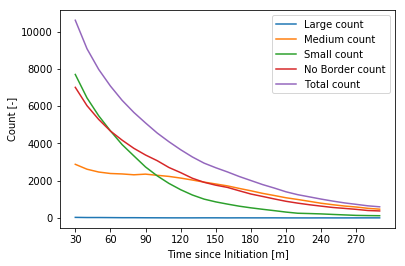

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

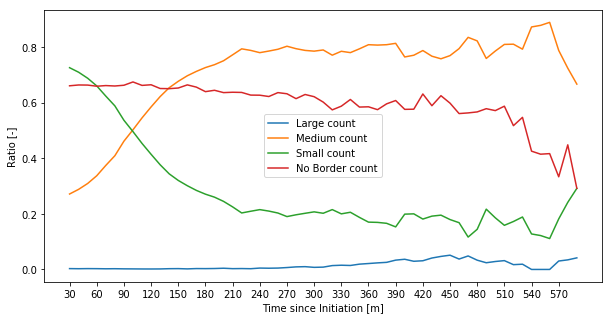

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = (categories['not_border'] & categories['not_border_0']
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary']
                & categories['sig_vel_mag'])
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2])
                            for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 91/91 [00:00<00:00, 170.20it/s]


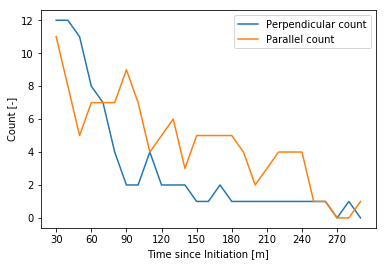

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

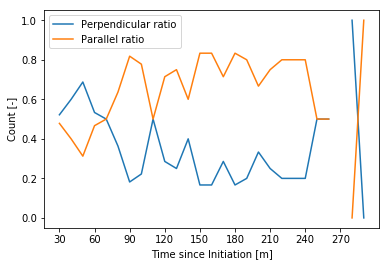

In [15]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

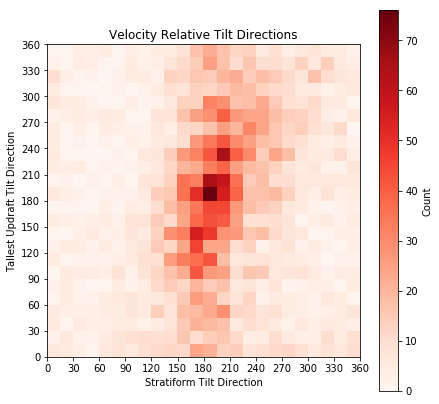

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

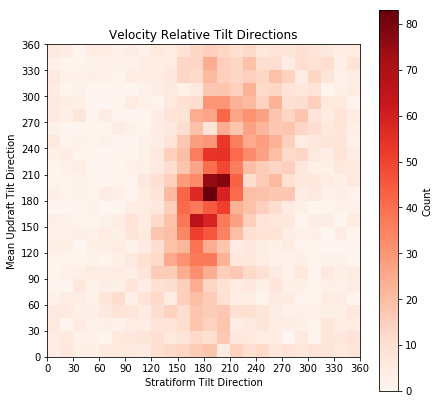

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')